# SALT \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega \end{equation*}
## **ECCO**

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.5.126:35851")
client

Client Scheduler: tcp://10.32.5.126:35851 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 30 Cores: 60 Memory: 345.00 GB


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
xr.set_options(display_style='text')

In [4]:
coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/coords_wg.zarr')) #didn't upload wg region
ds_tns = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_tns.zarr'))
ds_slt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_slt_wg_new.zarr'))
#ds_tmp = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_tmp_wg.zarr'))
ds_vel = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_vel.zarr'))
ds = xr.merge([ds_tns, ds_slt, ds_vel])
ds

<xarray.Dataset>
Dimensions:     (i: 95, i_g: 96, j: 50, j_g: 51, k: 50, k_l: 50, time: 288, time_snp: 287)
Coordinates:
  * k           (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * time_snp    (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * k_l         (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: i, i_g, j, j_g
Data variables:
    SALT        (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    SALT_snp    (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    THETA       (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    THETA_snp   (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    dt          (time) float32 dask.array<chunksize=(288,), meta=np.ndarray>
    G_adv       (time, k, j, i) float32 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    G_adv_conv  (time, k, j, i) float32 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    G_diff      (time, k, j, i) float32 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    G_forc      (time, k, j, i) float32 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    G_tot       (time, k, j, i) float32 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    UVEL        (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    UVELSTAR    (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    VVEL        (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 51, 67), meta=np.ndarray>
    VVELSTAR    (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 51, 67), meta=np.ndarray>
    WVEL        (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    WVELSTAR    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>

In [5]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 80 #-61.755745˚ instead of #79:-62.216576˚ to fill upper projection plot row
j_g_upper = 81
i_g_right = 119
i_g_left = 22

In [6]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat), j_g=slice(lower_lat, j_g_upper))
lon_range = dict(i=slice(left_lon, right_lon), i_g=slice(left_lon, i_g_right))

In [7]:
#set the boundaries
lat_range_noface = dict(j=slice(lower_lat, upper_lat))
lon_range_noface = dict(i=slice(left_lon, right_lon))

### Checking if `rhs` and `lhs` seem to match

In [11]:
rhs_vars = [dvar for dvar in ds_slt.data_vars
            if dvar != 'G_tot']
total_tendency_check = sum([ds_slt[dvar] for dvar in rhs_vars])
total_tendency_check

<xarray.DataArray (time: 288, k: 50, j: 50, i: 95)>
dask.array<add, shape=(288, 50, 50, 95), dtype=float32, chunksize=(48, 50, 50, 67), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i

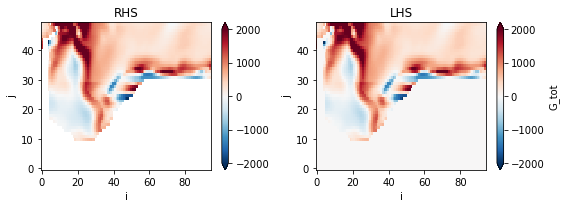

In [12]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
total_tendency_check[1, 0].plot(ax=ax0, robust=True, vmax=2e3)
ax0.set_title('RHS')

ds.G_tot[1, 0].plot(ax=ax1, robust=True, vmax=2e3)
ax1.set_title('LHS')
plt.tight_layout();

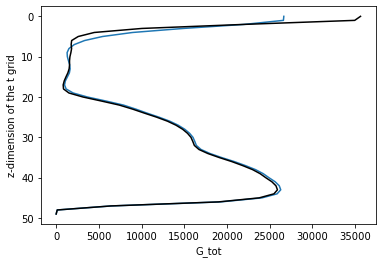

In [13]:
delta_salt = ds.SALT_snp.isel(time_snp=-1) - ds.SALT_snp.isel(time_snp=0)
total_time = (ds.time_snp[-1] - ds.time_snp[0]).astype('f8')*1e-9

vol = (coords.drF * coords.rA * coords.hFacC)
((delta_salt * vol).sum(dim=['j', 'i'])/ total_time).plot(y='k', yincrease=False)
ds.G_tot.sum(dim=['j', 'i']).mean(dim='time').plot(y='k', yincrease=False, color='k')

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-SLT-truth} + R1 \end{equation*} </font>

In [17]:
ds.SALT_snp.max().values

array(35.81289, dtype=float32)

In [18]:
ds.SALT_snp.min().values

array(0., dtype=float32)

In [14]:
# define bins
delta_salt = 0.01
salt_bins = np.arange(32, 36, delta_salt)

In [35]:
salt_bins.size

400

In [15]:
# salt distribution in WG region
vol = (coords.hFacC * coords.rA * coords.drF)

salt_dist = histogram(ds.SALT_snp.rename('salt'), bins=[salt_bins],
                       weights=vol, dim=['i', 'j', 'k'])
salt_dist.load()

<xarray.DataArray 'histogram_salt' (time_snp: 287, salt_bin: 399)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time_snp  (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * salt_bin  (salt_bin) float64 32.0 32.02 32.02 32.03 ... 35.96 35.97 35.98

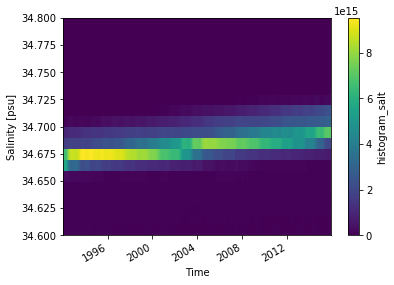

In [16]:
salt_dist.plot(x='time_snp'), plt.ylim(ymin=34.6, ymax=34.8);

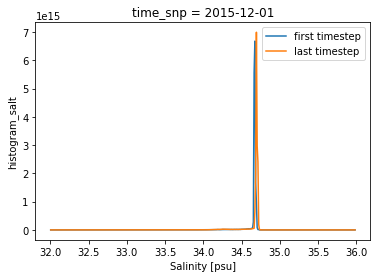

In [17]:
salt_dist[0].plot(label='first timestep')
salt_dist[-1].plot(label='last timestep')
plt.legend();

(34, 35.9899999999992)

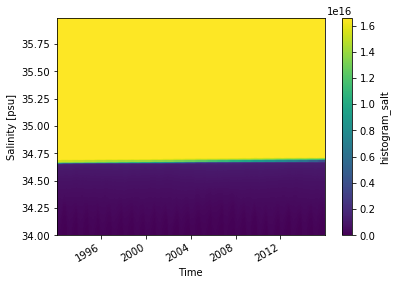

In [18]:
# cumulative volume
V = salt_dist.cumsum(dim='salt_bin')
V.transpose().plot()
plt.ylim(ymin=34)

In [19]:
V

<xarray.DataArray 'histogram_salt' (time_snp: 287, salt_bin: 399)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.65797187e+16, 1.65797187e+16, 1.65797187e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.65797187e+16, 1.65797187e+16, 1.65797187e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.65797187e+16, 1.65797187e+16, 1.65797187e+16],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.65797187e+16, 1.65797187e+16, 1.65797187e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.65797187e+16, 1.65797187e+16, 1.65797187e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.65797187e+16, 1.65797187e+16, 1.65797187e+16]])
Coordinates:
  * time_snp  (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * salt_bin  (salt_bin) float64 32.0 32.02 32.02 32.03 ... 35.96 35.97 35.98

In [20]:
delta_V = V.diff(dim='time_snp')
delta_V.coords['time'] = 'time_snp', ds.time[1:-1].values

In [21]:
delta_V

<xarray.DataArray 'histogram_salt' (time_snp: 286, salt_bin: 399)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time_snp  (time_snp) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
  * salt_bin  (salt_bin) float64 32.0 32.02 32.02 32.03 ... 35.96 35.97 35.98
    time      (time_snp) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

In [22]:
ds.dt[1:-1]

<xarray.DataArray 'dt' (time: 286)>
dask.array<getitem, shape=(286,), dtype=float32, chunksize=(286,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

## $\frac{\partial \mathcal{V}}{\partial t}$

In [23]:
dVdt = delta_V.swap_dims({'time_snp': 'time'}) / ds.dt[1:-1]

(33, 35)

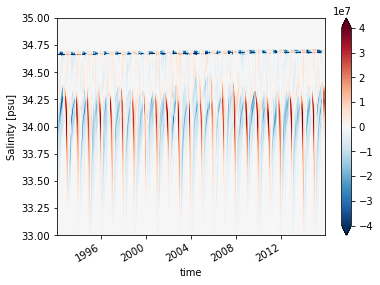

In [24]:
dVdt.plot(x='time', vmax=4e7)
plt.ylim(33, 35)

## $\Omega_{total}$

In [29]:
omega_total = - histogram(ds.SALT.rename('salt').chunk({'i':-1}), bins=[salt_bins],
                         weights=ds.G_tot.chunk({'i':-1, 'time':1}),
                         dim=['i', 'j', 'k']) / delta_salt
omega_total.load()

<xarray.DataArray 'histogram_salt' (time: 288, salt_bin: 399)>
array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])
Coordinates:
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * salt_bin  (salt_bin) float64 32.0 32.02 32.02 32.03 ... 35.96 35.97 35.98

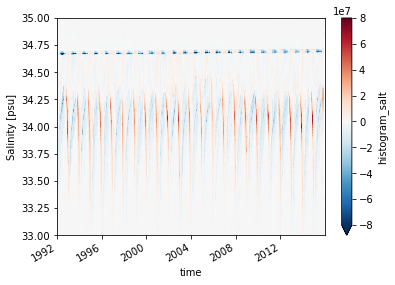

In [30]:
omega_total.plot(x='time', vmax=8e7)
plt.ylim(33, 35);

## <font color='Green'>\begin{equation*} R1 = \frac{\partial \mathcal{V}}{\partial t} - \Omega_{total} \end{equation*} (Discretization of salt layers) </font>

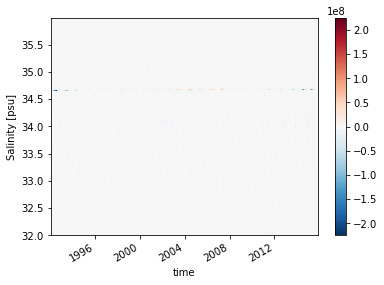

In [31]:
R1 = (dVdt.drop('time_snp').chunk({'time':1}) - omega_total[1:-1]).load()
R1.plot(x='time')

(-1, 0.5)

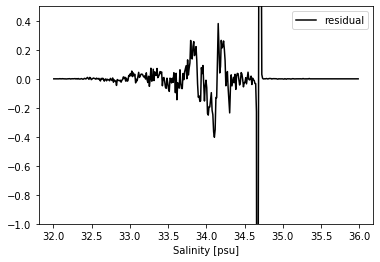

In [34]:
(R1/1e6).mean(dim='time').plot(color='k', label='residual')
plt.legend()
plt.ylim(-1, 0.5)

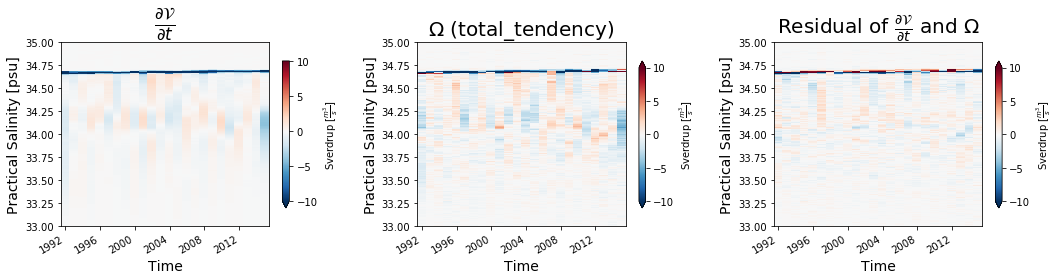

In [49]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

(dVdt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax0, vmax=10,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylabel('Practical Salinity [psu]', fontsize=14)
ax0.set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$', fontsize=24)
ax0.set_ylim(33, 35)

(omega_total[1:-1]/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax1, vmax=10, 
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylabel('Practical Salinity [psu]', fontsize=14)
ax1.set_xlabel('Time', fontsize=14)
ax1.set_title('$\Omega$ (total_tendency)', fontsize=20)
ax1.set_ylim(33, 35)

(R1/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax2, vmax=10, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylabel('Practical Salinity [psu]', fontsize=14)
ax2.set_xlabel('Time', fontsize=14)
ax2.set_title(r'Residual of $\frac{\partial \mathcal{V}}{\partial t}$ and $\Omega$', fontsize=20)
ax2.set_ylim(33, 35)

plt.tight_layout();

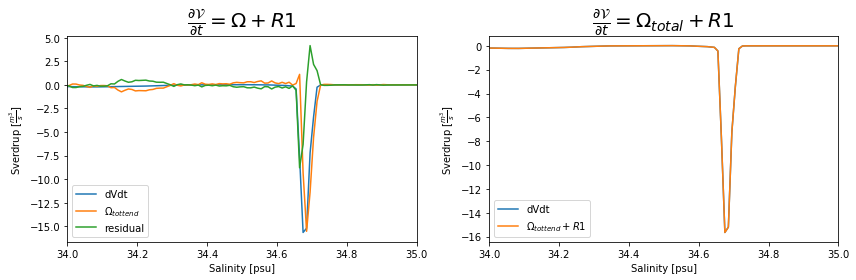

In [52]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=ax0)
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax0)
(R1/1e6).mean(dim='time').plot(label='residual', ax=ax0)
ax0.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax0.set_xlabel('Salinity [psu]')
ax0.legend()
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega + R1$', fontsize=20)
ax0.set_xlim(34, 35)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=ax1)
((omega_total + R1)/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} + R1$', ax=ax1)
ax1.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax1.legend()
ax1.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$', fontsize=20)
ax1.set_xlim(34, 35)

plt.tight_layout();

## <span style='color:Green'> \begin{equation*} \Omega_{transformation-rate} \end{equation*}

In [53]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for adv and diff flux terms"""
    hist = histogram(ds.SALT.rename('salt').chunk({'i':-1}), bins=[salt_bins],
                     weights=variable.fillna(0.), dim=['i', 'j', 'k'])
    return hist / delta_salt

In [54]:
all_tendencies = list(ds_slt)
all_tendencies

['conv_horiz_adv_flux_SLT',
 'conv_horiz_diff_flux_SLT',
 'conv_vert_adv_flux_SLT',
 'conv_vert_diff_flux_SLT',
 'salt_plume',
 'surface_flux_SLT',
 'total_tendency_SLT_truth']

In [55]:
all_dsets = xr.merge([histogram_func(ds_slt[var]).rename('OMEGA_' + var)
                      for var in all_tendencies])
all_dsets

<xarray.Dataset>
Dimensions:                         (salt_bin: 399, time: 288)
Coordinates:
  * time                            (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * salt_bin                        (salt_bin) float64 32.0 32.02 ... 35.98
Data variables:
    OMEGA_conv_horiz_adv_flux_SLT   (time, salt_bin) float64 dask.array<chunksize=(1, 399), meta=np.ndarray>
    OMEGA_conv_horiz_diff_flux_SLT  (time, salt_bin) float64 dask.array<chunksize=(1, 399), meta=np.ndarray>
    OMEGA_conv_vert_adv_flux_SLT    (time, salt_bin) float64 dask.array<chunksize=(1, 399), meta=np.ndarray>
    OMEGA_conv_vert_diff_flux_SLT   (time, salt_bin) float64 dask.array<chunksize=(1, 399), meta=np.ndarray>
    OMEGA_salt_plume                (time, salt_bin) float64 dask.array<chunksize=(1, 399), meta=np.ndarray>
    OMEGA_surface_flux_SLT          (time, salt_bin) float64 dask.array<chunksize=(1, 399), meta=np.ndarray>
    OMEGA_total_tendency_SLT_truth  (time, salt_bin) float64 dask.array<chunksize=(1, 399), meta=np.ndarray>

(33, 35)

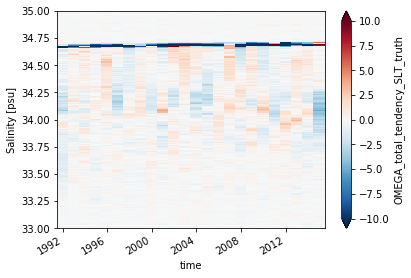

In [58]:
#checking to see if it looks the same as omega_total subplot above (and it does)
(-all_dsets.OMEGA_total_tendency_SLT_truth/1e6).resample(time='AS').mean(dim='time').plot(x='time', vmax=10)
plt.ylim(33, 35)

In [57]:
omega_trans_rate = - (all_dsets.OMEGA_conv_horiz_diff_flux_SLT + 
                      all_dsets.OMEGA_conv_vert_diff_flux_SLT +
                      all_dsets.OMEGA_salt_plume + 
                      all_dsets.OMEGA_surface_flux_SLT)
omega_trans_rate.load()

<xarray.DataArray (time: 288, salt_bin: 399)>
array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])
Coordinates:
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * salt_bin  (salt_bin) float64 32.0 32.02 32.02 32.03 ... 35.96 35.97 35.98

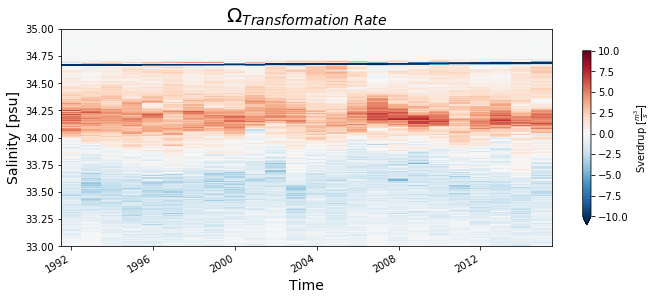

In [61]:
(omega_trans_rate.resample(time='AS').mean()/1e6).plot(x='time', figsize=(11,4), vmax=10,
                                                       cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel('Salinity [psu]', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title(r'$\Omega_{Transformation\ Rate}$', fontsize=20)
plt.ylim(33, 35);

## <font color='Green'> \begin{equation*} \Psi_{adv} = \Psi_{vel} + R2 \end{equation*} (Numerical Mixing) </font>

## $\Psi_{adv}$

In [62]:
psi_adv = -(all_dsets.OMEGA_conv_horiz_adv_flux_SLT + all_dsets.OMEGA_conv_vert_adv_flux_SLT)
psi_adv.load()

<xarray.DataArray (time: 288, salt_bin: 399)>
array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])
Coordinates:
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * salt_bin  (salt_bin) float64 32.0 32.02 32.02 32.03 ... 35.96 35.97 35.98

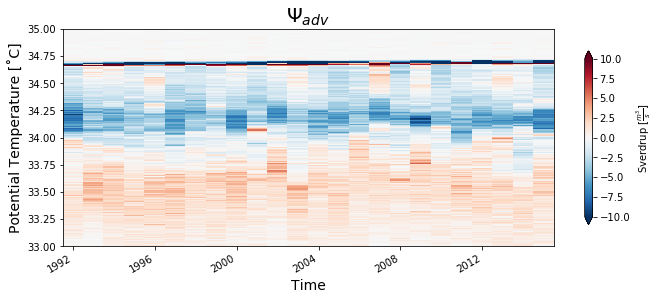

In [64]:
(psi_adv/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(11,4), vmax=10,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel('Potential Temperature [˚C]', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title(r'$\Psi_{adv}$', fontsize=20)
plt.ylim(33, 35);

## $\Psi_{vel}$

In [65]:
#this is the "dA" part of the equation
u_transport_right = (ds.UVEL * coords.dyG * coords.drF).isel(i_g=-1) #m^3/s #(-) values -> westward, (+) values -> east
u_transport_left = (ds.UVEL * coords.dyG * coords.drF).isel(i_g=0)
v_transport = (ds.VVEL * coords.dxG * coords.drF).isel(j_g=-1) #m^3/s #(-) values -> south, (+) values -> north
w_transport = ds.WVEL.isel(k_l=0) * coords.rA #m^3/s #(-) values are massflux into the ocean, (+) values are massflux out of the ocean

In [66]:
u_transport_mean_value = (u_transport_right.sum(dim=['j', 'k']) -
                          u_transport_left.sum(dim=['j', 'k'])).mean(dim='time')/1e6
u_transport_mean_value.load()

<xarray.DataArray ()>
array(-38.406273, dtype=float32)

In [82]:
v_transport_mean_value = v_transport.mean(dim='time').sum()/1e6
v_transport_mean_value.load()

<xarray.DataArray ()>
array(38.4216, dtype=float32)

In [83]:
w_transport_mean_value = w_transport.mean(dim='time').sum()/1e6
w_transport_mean_value.load()

<xarray.DataArray ()>
array(-0.01507538, dtype=float32)
Coordinates:
    k_l      int64 0

In [84]:
residual = u_transport_mean_value + v_transport_mean_value + w_transport_mean_value
residual

<xarray.DataArray ()>
array(0.00025208, dtype=float32)
Coordinates:
    k_l      int64 0

In [87]:
# hack theta to be on same grid pt as velocity components
salt_at_u_right = ds.SALT.isel(i=-1)
salt_at_u_left = ds.SALT.isel(i=0)
salt_at_v = ds.SALT.isel(j=-1)
salt_at_w = ds.SALT.isel(k=0)

In [108]:
#this is the delta function part of the equation above
u_binned_right = histogram(salt_at_u_right.rename('salt'), bins=[salt_bins],
                     weights=u_transport_right, dim=['k', 'j'])
u_binned_left = histogram(salt_at_u_left.rename('salt'), bins=[salt_bins],
                     weights=u_transport_left, dim=['k', 'j'])
v_binned = histogram(salt_at_v.rename('salt'), bins=[salt_bins],
                     weights=v_transport, dim=['k', 'i'])
w_binned = histogram(salt_at_w.rename('salt'), bins=[salt_bins],
                     weights=w_transport, dim=['i', 'j'])

In [109]:
psi_vel = -(u_binned_right + u_binned_left + v_binned + w_binned).cumsum(dim='salt_bin')
psi_vel.load()

<xarray.DataArray 'histogram_salt' (time: 288, salt_bin: 39)>
array([[       -0.        ,        -0.        ,        -0.        , ...,
        -30346458.95936992, -30346458.95936992, -30346458.95936992],
       [       -0.        ,        -0.        ,        -0.        , ...,
        -27730620.46058103, -27730620.46058103, -27730620.46058103],
       [       -0.        ,        -0.        ,        -0.        , ...,
        -32338583.66775652, -32338583.66775652, -32338583.66775652],
       ...,
       [       -0.        ,        -0.        ,        -0.        , ...,
        -33447297.34452934, -33447297.34452934, -33447297.34452934],
       [       -0.        ,        -0.        ,        -0.        , ...,
        -29629920.64110489, -29629920.64110489, -29629920.64110489],
       [       -0.        ,        -0.        ,        -0.        , ...,
        -27555502.56662291, -27555502.56662291, -27555502.56662291]])
Coordinates:
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * salt_bin  (salt_bin) float64 32.05 32.15 32.25 32.35 ... 35.65 35.75 35.85

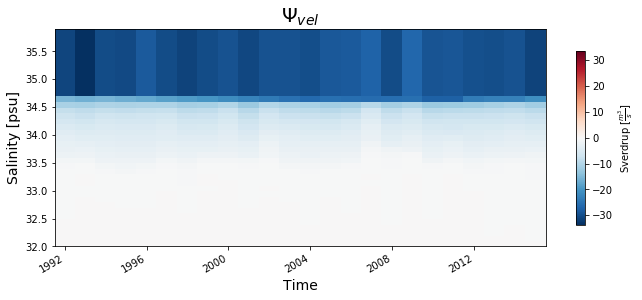

In [110]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(11,4), 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel('Salinity [psu]', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('$\Psi_{vel}$', fontsize=20);

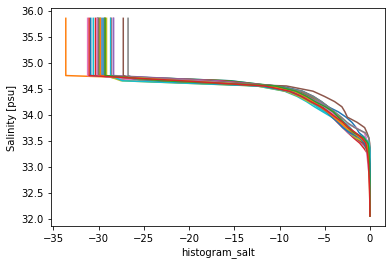

In [92]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot.line(y='salt_bin', add_legend=False);

## R2 = $\Psi_{adv} - \Psi_{vel}$ (Numerical Mixing)

In [96]:
R2 = psi_adv - psi_vel

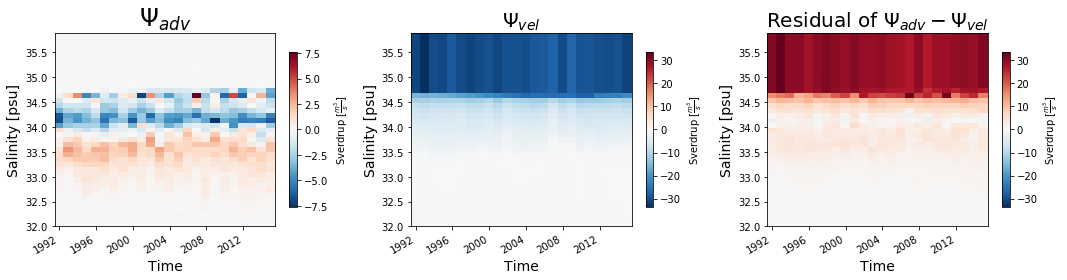

In [97]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

(psi_adv/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax0,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylabel('Salinity [psu]', fontsize=14)
ax0.set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\Psi_{adv}$', fontsize=24)

(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax1, 
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylabel('Salinity [psu]', fontsize=14)
ax1.set_xlabel('Time', fontsize=14)
ax1.set_title('$\Psi_{vel}$', fontsize=20)

(R2/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax2, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylabel('Salinity [psu]', fontsize=14)
ax2.set_xlabel('Time', fontsize=14)
ax2.set_title(r'Residual of $\Psi_{adv} - \Psi_{vel}$', fontsize=20)

plt.tight_layout();

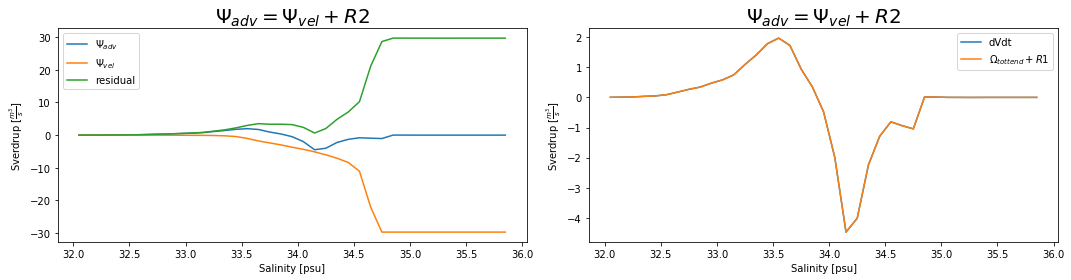

In [98]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}$', ax=ax0)
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=ax0)
(R2/1e6).mean(dim='time').plot(label='residual', ax=ax0)
ax0.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax0.set_xlabel('Salinity [psu]')
ax0.legend()
ax0.set_title(r'$\Psi_{adv} = \Psi_{vel} + R2$', fontsize=20)

(psi_adv/1e6).mean(dim='time').plot(label='dVdt', ax=ax1)
((psi_vel + R2)/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} + R1$', ax=ax1)
ax1.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax1.set_xlabel('Salinity [psu]')
ax1.legend()
ax1.set_title(r'$\Psi_{adv} = \Psi_{vel} + R2$', fontsize=20)

plt.tight_layout();

# <font color='Green'>\begin{equation*} \Omega_{tottend-truth} = \Psi_{adv} + \Omega_{trans-rate} + R3 \end{equation*} </font>

In [111]:
R3 = omega_total - (psi_adv + omega_trans_rate)
R3.load()

<xarray.DataArray (time: 288, salt_bin: 39)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * salt_bin  (salt_bin) float64 32.05 32.15 32.25 32.35 ... 35.65 35.75 35.85

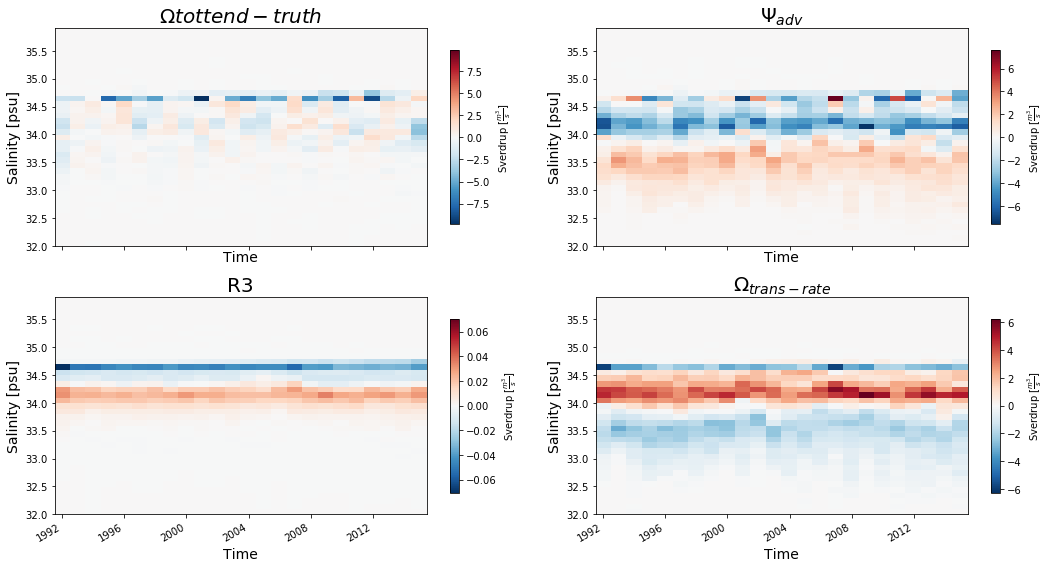

In [115]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8), sharex=True)

(omega_total/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[0,0],
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[0,0].set_ylabel('Salinity [psu]', fontsize=14)
ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\Omega{tottend-truth}$', fontsize=20)

(psi_adv/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[0,1], 
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[0,1].set_ylabel('Salinity [psu]', fontsize=14)
ax[0,1].set_xlabel('Time', fontsize=14)
ax[0,1].set_title('$\Psi_{adv}$', fontsize=20)

(R3/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[1,0], 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[1,0].set_ylabel('Salinity [psu]', fontsize=14)
ax[1,0].set_xlabel('Time', fontsize=14)
ax[1,0].set_title('R3', fontsize=20)

(omega_trans_rate/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[1,1], 
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[1,1].set_ylabel('Salinity [psu]', fontsize=14)
ax[1,1].set_xlabel('Time', fontsize=14)
ax[1,1].set_title('$\Omega_{trans-rate}$', fontsize=20)

plt.tight_layout();

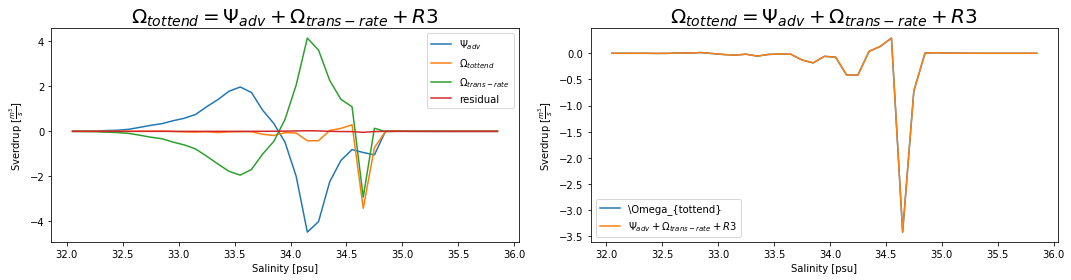

In [116]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}$', ax=ax0)
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax0)
(omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega_{trans-rate}$', ax=ax0)
(R3/1e6).mean(dim='time').plot(label='residual', ax=ax0)
ax0.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax0.set_xlabel('Salinity [psu]')
ax0.legend()
ax0.set_title(r'$\Omega_{tottend} = \Psi_{adv} + \Omega_{trans-rate} + R3$', fontsize=20)

(omega_total/1e6).mean(dim='time').plot(label='\Omega_{tottend}', ax=ax1)
((psi_adv + omega_trans_rate + R3)/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}+\Omega_{trans-rate}+R3$', ax=ax1)
ax1.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax1.set_xlabel('Salinity [psu]')
ax1.legend()
ax1.set_title(r'$\Omega_{tottend} = \Psi_{adv} + \Omega_{trans-rate} + R3$', fontsize=20)

plt.tight_layout();

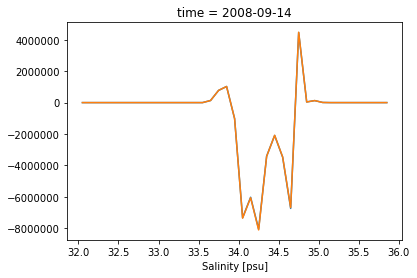

In [117]:
n = 200
omega_total.isel(time=n).plot()
(omega_trans_rate + psi_adv).isel(time=n).plot()


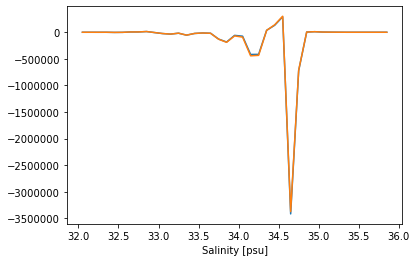

In [118]:
omega_total.isel(time=slice(1, -1)).mean(dim='time').plot()
(omega_trans_rate + psi_adv).isel(time=slice(1, -1)).mean(dim='time').plot()

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} = \Psi_{adv} + \Omega_{trans-rate} + R3 + R1\end{equation*} </font>

In [119]:
dVdt

<xarray.DataArray (time: 286, salt_bin: 39)>
dask.array<true_divide, shape=(286, 39), dtype=float64, chunksize=(286, 39), chunktype=numpy.ndarray>
Coordinates:
    time_snp  (time) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
  * salt_bin  (salt_bin) float64 32.05 32.15 32.25 32.35 ... 35.65 35.75 35.85
  * time      (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

In [124]:
R3

<xarray.DataArray (time: 288, salt_bin: 39)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * salt_bin  (salt_bin) float64 32.05 32.15 32.25 32.35 ... 35.65 35.75 35.85

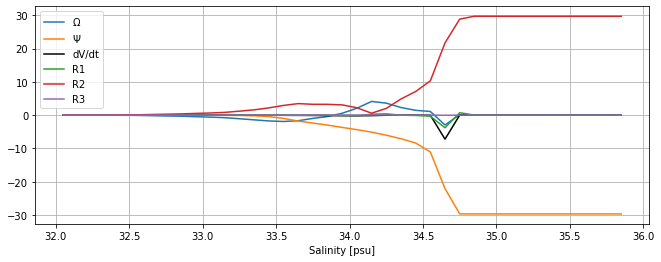

In [126]:
(omega_trans_rate[1:-1]/1e6).mean(dim='time').plot(figsize=(11,4), label=r'$\Omega$')
(psi_vel[1:-1]/1e6).mean(dim='time').plot(label=r'$\Psi$')
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k')
(R1/1e6).mean(dim='time').plot(label='R1')
(R2[1:-1]/1e6).mean(dim='time').plot(label='R2')
(R3[1:-1]/1e6).mean(dim='time').plot(label='R3')
plt.legend()
plt.grid();

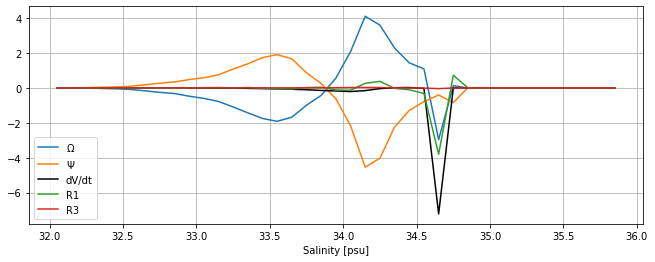

In [131]:
(omega_trans_rate[1:-1]/1e6).mean(dim='time').plot(figsize=(11,4), label=r'$\Omega$')
(psi_adv[1:-1]/1e6).mean(dim='time').plot(label=r'$\Psi$')
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k')
(R1/1e6).mean(dim='time').plot(label='R1')
(R3[1:-1]/1e6).mean(dim='time').plot(label='R3')
plt.legend()
plt.grid();

### **Explanation:**
- If you have positive transformation in $\sigma$ bins, the water is getting lighter. So if you have positive transformation in $\theta$ bins, that means the water is getting warmer, no? And similarly, negative transformation in $\sigma$ bins means water is getting denser, so negative transformation in $\theta$ bins means water is getting colder.

In [134]:
omega_mix = -(all_dsets.OMEGA_conv_horiz_diff_flux_SLT + 
              all_dsets.OMEGA_conv_vert_diff_flux_SLT + 
              all_dsets.OMEGA_salt_plume)
omega_surf = - all_dsets.OMEGA_surface_flux_SLT

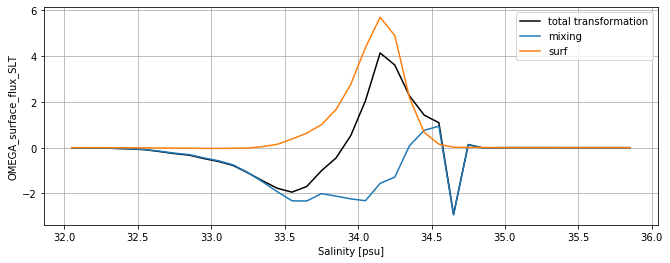

In [136]:
(omega_trans_rate/1e6).mean(dim='time').plot(figsize=(11,4), label='total transformation', color='k')
(omega_mix/1e6).mean(dim='time').plot(label='mixing')
(omega_surf/1e6).mean(dim='time').plot(label='surf')
plt.legend()
plt.grid();

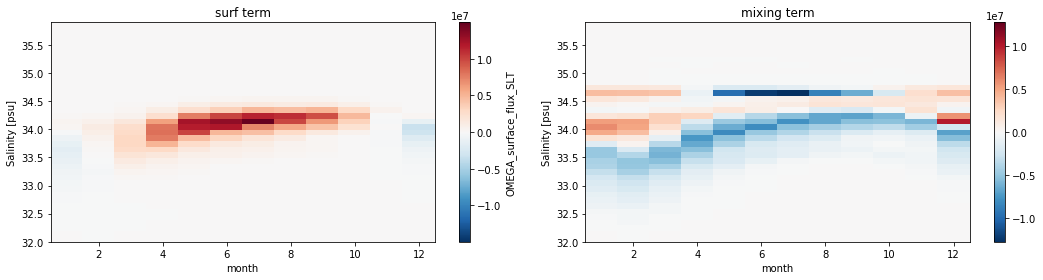

In [142]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(15,4))

omega_surf.groupby('time.month').mean(dim='time').plot(x='month', ax=ax0)
ax0.set_title('surf term')

omega_mix.groupby('time.month').mean(dim='time').plot(x='month', ax=ax1)
ax1.set_title('mixing term')

plt.tight_layout();

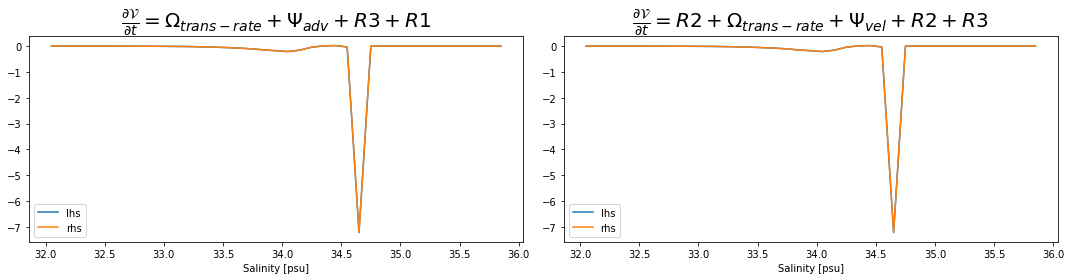

In [140]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(15,4))

(dVdt/1e6).mean(dim='time').plot(label='lhs', ax=ax0) 
((omega_trans_rate[1:-1] + psi_adv[1:-1] + R3[1:-1] + R1)/1e6).mean(dim='time').plot(label='rhs', ax=ax0)
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{trans-rate} + \Psi_{adv} + R3 + R1$', fontsize=20, fontweight='bold')
ax0.legend()

(dVdt/1e6).mean(dim='time').plot(label='lhs', ax=ax1) 
((omega_trans_rate[1:-1] + R1 + psi_vel[1:-1] + R2[1:-1] + R3[1:-1])/1e6).mean(dim='time').plot(label='rhs', ax=ax1)
ax1.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = R2 + \Omega_{trans-rate} + \Psi_{vel} + R2 + R3$', fontsize=20, fontweight='bold')
ax1.legend()

plt.tight_layout();

## <span style='background:Yellow'> Checking to see if orig ds works </span>
for tendency term & velocity terms for `Psi_{vel}`

In [7]:
ds1 = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-eccov4r3/eccov4r3'), consolidated=True)

In [8]:
ds_ll = faces_dataset_to_latlon(ds1)
ds_ll_drop = ds_ll.drop(['i', 'j', 'i_g', 'j_g']) #, 'k', 'k_u', 'k_l', 'k_p1'])

In [9]:
# a trick to make things work a bit faster
coords = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=50, i_g=50)
ds1 = ds_ll_drop.reset_coords(drop=True).roll(i=50, i_g=50)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
ds_weddell = ds1.isel(**lon_range, **lat_range)
ds_weddell.nbytes/1e6

6091.898312

In [14]:
coords_weddell = coords.isel(**lat_range, **lon_range)

In [122]:
#calculating total tendency term for salt
salt_scaled = (ds.SALT_snp * (1 + (ds_weddell.ETAN_snp / coords_weddell.Depth))).diff('time_snp')

#forcing salt_scaled to have same timestamp as ds.dt by creating new data array called "salt_scaled"
salt_scaled = xr.DataArray(salt_scaled.data, dims=['time','k','j','i'], 
                            coords={'time': ds.dt[1:287].time.data})
salt_scaled
#units: g/kg (psu)

<xarray.DataArray 'sub-b64f34edf67336d22dcf79cae88801d6' (time: 286, k: 50, j: 50, i: 95)>
dask.array<sub, shape=(286, 50, 50, 95), dtype=float32, chunksize=(1, 50, 50, 67), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
Dimensions without coordinates: k, j, i

In [123]:
salt_tend = (salt_scaled / ds.dt[1:287])
#units: g/kg*s (psu/s)

In [125]:
volume = (coords_weddell.drF * coords_weddell.rA * coords_weddell.hFacC)
#day2seconds = (24*60*60)
totstend = salt_tend * volume

In [136]:
omega_total = - histogram(ds.SALT[1:-1].rename('salt').chunk({'i':-1}), bins=[salt_bins],
                         weights=totstend.chunk({'i':-1}),
                         dim=['i', 'j', 'k']) / delta_salt
omega_total.load()

<xarray.DataArray 'histogram_salt' (time: 286, salt_bin: 39)>
array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])
Coordinates:
  * time      (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
  * salt_bin  (salt_bin) float64 32.05 32.15 32.25 32.35 ... 35.65 35.75 35.85